In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# from keras.utils.np_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import Callback
from keras.optimizers import Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data pre-processing
# normalize the input data
x_train = x_train.reshape(*x_train.shape, 1) / 255.    # normalize
x_test = x_test.reshape(*x_test.shape, 1) / 255.      # normalize

# one-hot output data
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [3]:
def cnn():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))

    model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

model = cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

Epoch 1/2
1875/1875 [==============================] - 13s 5ms/step - loss: 0.3540 - accuracy: 0.8829 - val_loss: 0.0392 - val_accuracy: 0.9869
Epoch 2/2
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0688 - accuracy: 0.9803 - val_loss: 0.0279 - val_accuracy: 0.9910


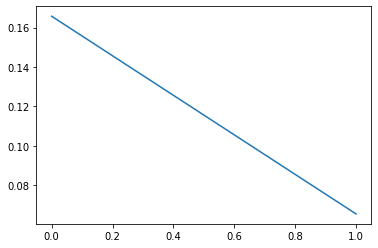

In [4]:
hist = model.fit(x_train, y_train, 
                 validation_data = (x_test,y_test),
                 epochs=2)
plt.plot(hist.history["loss"])

# visualize the weights

2
[(3, 3, 32, 64), (64,)]


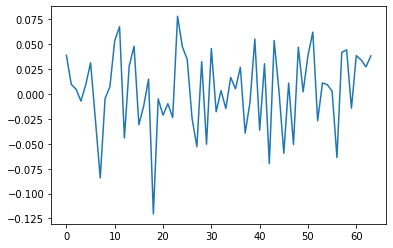

In [9]:
w = model.layers[4].get_weights()

print(len(w))
# print(w)
print([wi.shape for wi in w])

plt.plot(w[1].ravel())

# Weights change curve

In [13]:
class RecordWeights(Callback):
    def __init__(self, i_layer, i_weight, name_layer, verbose=False):
        super(RecordWeights, self).__init__()
        self.i_layer = i_layer
        self.i_weight = i_weight
        self.name_layer = name_layer
        
        self.verbose=verbose
        
    def on_epoch_end(self, epoch, logs=None):
        w = self.model.layers[self.i_layer].get_weights()[self.i_weight]
        self.model.history.history.setdefault("w_" + self.name_layer, []).append(w)
        
        if self.verbose:
            print("weights on layer {}({}): {}".format(self.i_layer, self.name_layer, w))
            
    def on_train_start(self, epoch, logs=None):
        self.on_epoch_end(epoch, logs=logs)
        
    @staticmethod
    def plot_w(name_layer, history):
        name = "w_" + name_layer
        
        n_epochs = len(history[name])
        alphas = np.linspace(0.1, 1, n_epochs)
        
        plt.plot(history[name][0].ravel(), c="g")
        for i in range(1, n_epochs-1):
            plt.plot(history[name][i].ravel(), c="b", alpha=alphas[i])
        plt.plot(history[name][-1].ravel(), c="r")
        
        plt.show()
    

In [16]:
model = cnn()

Epoch 1/12
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3559 - accuracy: 0.8849 - val_loss: 0.0498 - val_accuracy: 0.9842
Epoch 2/12
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.0508 - val_accuracy: 0.9841
Epoch 3/12
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0479 - accuracy: 0.9863 - val_loss: 0.0252 - val_accuracy: 0.9909
Epoch 4/12
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0389 - accuracy: 0.9883 - val_loss: 0.0199 - val_accuracy: 0.9932
Epoch 5/12
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0374 - accuracy: 0.9885 - val_loss: 0.0196 - val_accuracy: 0.9941
Epoch 6/12
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0331 - accuracy: 0.9899 - val_loss: 0.0285 - val_accuracy: 0.9920
Epoch 7/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0180 - val_accurac

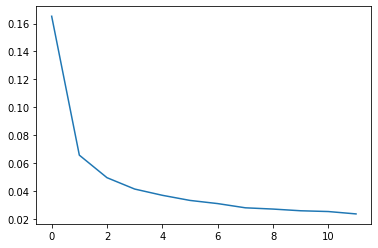

In [17]:
hist = model.fit(x_train, y_train, 
                 validation_data = (x_test,y_test),
                 callbacks=[RecordWeights(4, 1, "b2"),],
                 epochs=12)
plt.plot(hist.history["loss"])

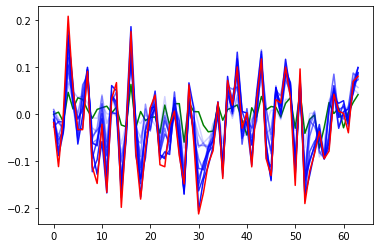

In [18]:
RecordWeights.plot_w("b2", hist.history)

# Weights change curves in 3D

In [26]:
def plot_w_3d(name_layer, history):
    name = "w_" + name_layer

    n_epochs = len(history[name])
    n_weights = len(history[name][0])

    x = np.arange(n_weights)
    y = np.arange(n_epochs)
    X,Y = np.meshgrid(x, y)
    
    Z = np.array(history[name])
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    colors =plt.cm.magma( (Y-Y.min())/float((Y-Y.min()).max()) )
    ax.plot_surface(X, Y, Z, facecolors=colors)
    
    ax.set_xlabel("Weights")
    ax.set_ylabel("Epochs")
    
    plt.show()
    
    

In [27]:
%matplotlib qt

In [28]:
plot_w_3d("b2", hist.history)